In [1]:
!pip install -Uqq git+https://github.com/jaysinghr/DL-to-Diffusion@develop

In [2]:
#| default_exp learner

In [3]:
#|export
import math
import matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

import torch
from torch import optim
import torch.nn.functional as F

from minimalai.conv import *

from fastprogress import progress_bar,master_bar

In [4]:
import matplotlib as mpl
from contextlib import contextmanager

import torchvision.transforms.functional as TF
from torch import nn, tensor
from datasets import load_dataset, load_dataset_builder
from minimalai.datasets import *

import logging
from fastcore.test import test_close

In [5]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
logging.disable(logging.WARNING)

## Learner

In [7]:
# Define the keys for image and label
image_key, label_key = 'image', 'label'
# Specify the name of the dataset (e.g., "fashion_mnist")
dataset_name = "fashion_mnist"

# Load the dataset using the specified name
dataset_dict = load_dataset(dataset_name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [9]:
dataset_dict.values()

dict_values([Dataset({
    features: ['image', 'label'],
    num_rows: 60000
}), Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})])

In [10]:
# Define the function to transform the data inplace
@apply_inplace_transformation
def transform_images_inplace(batch):
    """
    Transform the images in the batch to tensors and flatten them inplace.

    Args:
    - batch (dict): A dictionary containing the batch of data.

    Returns:
    - dict: The transformed batch with images flattened as tensors.
    """
    batch[image_key] = [torch.flatten(TF.to_tensor(image)) for image in batch[image_key]]
    return batch

In [11]:
# Define the batch size for the data loader
batch_size = 1024

# Apply the transform function `transform_images_inplace` to the dataset `loaded_dataset`
transformed_dataset = dataset_dict.with_transform(transform_images_inplace)

In [12]:
# Create data loaders from the transformed dataset `transformed_dataset` with the specified batch size `batch_size` and number of workers `num_workers`
data_loaders = DataLoaders.from_dataset_dict(transformed_dataset, batch_size, num_workers=4)

# Get the training data loader from the created data loaders
train_data_loader = data_loaders.train_loader

# Get a batch of data from the training data loader
inputs_batch, labels_batch = next(iter(train_data_loader))

# Print the shape of the input batch and the first 10 labels
print("Input Batch Shape:", inputs_batch.shape)
print("First 10 Labels:", labels_batch[:10])

Input Batch Shape: torch.Size([1024, 784])
First 10 Labels: tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6])


In [13]:
class Learner:
    def __init__(self, model, data_loaders, loss_function, learning_rate, optimizer_function=optim.SGD):
        """
        Initialize a Learner object.

        Args:
        - model (nn.Module): The neural network model to be trained.
        - data_loaders (DataLoaders): The data loaders containing the training and validation datasets.
        - loss_function (callable): The loss function to be used for optimization.
        - learning_rate (float): The learning rate for the optimizer.
        - optimizer_function (callable): The optimizer function to be used (default is optim.SGD).
        """
        # Store the attributes of the Learner object
        self.model = model
        self.data_loaders = data_loaders
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.optimizer_function = optimizer_function

    def one_batch(self):
        """
        Perform one batch of training or validation.

        This method:
        - Moves the input and target tensors to the device.
        - Computes the predictions using the model.
        - Calculates the loss using the loss function.
        - Backpropagates the gradients and updates the model parameters if in training mode.
        - Calculates statistics such as accuracy and loss.
        """
        self.inputs_batch, self.labels_batch = move_data_to_device(self.batch)
        self.predictions = self.model(self.inputs_batch)
        self.loss = self.loss_function(self.predictions, self.labels_batch)
        if self.model.training:
            self.loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        with torch.no_grad():
            self.calculate_statistics()

    def calculate_statistics(self):
        """
        Calculate statistics such as accuracy and loss for the current batch.

        This method calculates:
        - Accuracy by comparing predicted labels with actual labels.
        - Loss multiplied by the batch size for accumulation.
        - Batch size for normalization.
        """
        accuracy = (self.predictions.argmax(dim=1) == self.labels_batch).float().sum()
        self.accuracies.append(accuracy)
        batch_size = len(self.inputs_batch)
        self.losses.append(self.loss * batch_size)
        self.batch_sizes.append(batch_size)

    def one_epoch(self, is_training):
        """
        Perform one epoch of training or validation.

        Args:
        - is_training (bool): Indicates whether the model is in training mode.

        This method:
        - Sets the model's training mode based on the `is_training` argument.
        - Iterates through the data loader for the specified mode.
        - Calls `one_batch()` for each batch in the data loader.
        - Prints epoch, training mode, average loss, and accuracy.
        """
        self.model.train(is_training)
        data_loader = self.data_loaders.train_loader if is_training else self.data_loaders.valid_loader
        for self.batch_num, self.batch in enumerate(data_loader):
            self.one_batch()
        total_samples = sum(self.batch_sizes)
        average_loss = sum(self.losses).item() / total_samples
        average_accuracy = sum(self.accuracies).item() / total_samples
        print(f"Epoch: {self.epoch}, Training: {is_training}, Average Loss: {average_loss}, Average Accuracy: {average_accuracy}")

    def fit(self, num_epochs):
        """
        Train the model for the specified number of epochs.

        Args:
        - num_epochs (int): The number of epochs to train the model.

        This method:
        - Initializes lists for tracking statistics (accuracies, losses, batch_sizes).
        - Moves the model to the default device.
        - Initializes the optimizer with the specified learning rate.
        - Iterates through epochs, calling `one_epoch()` for training and validation.
        """
        self.accuracies, self.losses, self.batch_sizes = [], [], []
        self.model.to(default_device)
        self.optimizer = self.optimizer_function(self.model.parameters(), self.learning_rate)
        self.num_epochs = num_epochs
        for self.epoch in range(num_epochs):
            self.one_epoch(True)
            with torch.no_grad():
                self.one_epoch(False)

In [14]:
# Define the input size and hidden layer size
input_size, hidden_layer_size = 28 * 28, 50

# Create a neural network model using nn.Sequential
model = nn.Sequential(
    # First linear layer: input size -> hidden layer size with ReLU activation
    nn.Linear(input_size, hidden_layer_size),
    nn.ReLU(),
    # Second linear layer: hidden layer size -> output size (10 classes)
    nn.Linear(hidden_layer_size, 10)
)

In [15]:
# Create a Learner object for training the model
learner = Learner(
    model=model,            # The neural network model to be trained
    data_loaders=data_loaders,       # The data loaders containing the training and validation datasets
    loss_function=F.cross_entropy,  # The loss function to be used for optimization
    learning_rate=0.2       # The learning rate for the optimizer
)

# Train the model for 1 epoch
learner.fit(1)

Epoch: 0, Training: True, Average Loss: 1.1753063802083332, Average Accuracy: 0.5986166666666667
Epoch: 0, Training: False, Average Loss: 1.1203783482142857, Average Accuracy: 0.6133857142857143


## Basic Callbacks Learner

In [16]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [17]:
#|export
class Callback():
    """
    Base class for callbacks used in the training process.

    Attributes:
    - order (int): The order in which the callback should be executed.
    """
    order = 0  # Default order value for the callback

In [18]:
#|export
def run_callbacks(callbacks, method_name, learner=None):
    """
    Run methods of the callbacks in the specified order.

    Args:
    - callbacks (list): List of callback objects.
    - method_name (str): Name of the method to be called in the callbacks.
    - learner (Learner, optional): The learner object to be passed to the callback methods.

    This function iterates through the list of callbacks, sorted by the 'order' attribute,
    and calls the specified method (method_name) on each callback object if it exists.
    """
    # Sort the callbacks based on the 'order' attribute
    sorted_callbacks = sorted(callbacks, key=attrgetter('order'))

    # Iterate through the sorted callbacks and call the specified method on each
    for callback in sorted_callbacks:
        method = getattr(callback, method_name, None)
        if method is not None:
            method(learner)

In [19]:
class CompletionCallback(Callback):
    """
    Callback for tracking the completion of batches during training.

    This callback updates a count of processed batches and prints the total count
    after the completion of the training process.

    Inherits from:
    - Callback: The base class for all callbacks.

    Methods:
    - before_fit: Executed before the start of the training process.
    - after_batch: Executed after processing each batch during training.
    - after_fit: Executed after the completion of the training process.
    """
    def before_fit(self, learner):
        """
        Initialize the batch count before the start of the training process.

        Args:
        - learner: The learner object used for training.
        """
        self.batch_count = 0

    def after_batch(self, learner):
        """
        Update the batch count after processing each batch.

        Args:
        - learner: The learner object used for training.
        """
        self.batch_count += 1

    def after_fit(self, learner):
        """
        Print the total number of completed batches after the training process.

        Args:
        - learner: The learner object used for training.
        """
        print(f'Total batches completed: {self.batch_count}')

In [20]:
# Create a list of callbacks containing a single instance of CompletionCallback
callbacks = [CompletionCallback()]

# Run the 'before_fit' method of the callbacks
run_callbacks(callbacks, 'before_fit')

# Simulate running the 'after_batch' method of the callbacks for a few batches
for _ in range(5):
    run_callbacks(callbacks, 'after_batch')

# Run the 'after_fit' method of the callbacks
run_callbacks(callbacks, 'after_fit')

Total batches completed: 5


In [21]:
class Learner:
    """
    Class for training a neural network model using callbacks.

    Attributes:
    - model (nn.Module): The neural network model to be trained.
    - data_loaders (DataLoaders): The data loaders containing the training and validation datasets.
    - loss_function (callable): The loss function to be used for optimization.
    - learning_rate (float): The learning rate for the optimizer.
    - callbacks (list): List of callbacks to be applied during training.
    - optimizer_function (callable): The optimizer function to be used (default is optim.SGD).
    """
    def __init__(self, model, data_loaders, loss_function, learning_rate, callbacks, optimizer=optim.SGD):
        """
        Initialize a Learner object for training a neural network model.

        Args:
        - model (nn.Module): The neural network model to be trained.
        - data_loaders (DataLoaders): The data loaders containing the training and validation datasets.
        - loss_function (callable): The loss function to be used for optimization.
        - learning_rate (float): The learning rate for the optimizer.
        - callbacks (list): List of callbacks to be applied during training.
        - optimizer_function (callable): The optimizer function to be used (default is optim.SGD).
        """
        self.model = model
        self.data_loaders = data_loaders
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.callbacks = callbacks
        self.optimizer = optimizer

    def process_batch(self):
        """
        Process a single batch of data.

        This method:
        - Computes the predictions using the model.
        - Calculates the loss using the loss function.
        - Backpropagates the gradients and updates the model parameters if in training mode.
        """
        self.predictions = self.model(self.batch[0])
        self.loss = self.loss_function(self.predictions, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def process_epoch(self, is_training):
        """
        Process a single epoch of training or validation.

        Args:
        - is_training (bool): Indicates whether the model is in training mode.

        This method:
        - Sets the model's training mode based on the `is_training` argument.
        - Iterates through the data loader for the specified mode.
        - Calls `process_batch()` for each batch in the data loader.
        """
        self.model.train(is_training)
        data_loader = self.data_loaders.train_loader if is_training else self.data_loaders.valid_loader
        try:
            self.callback('before_epoch')
            for self.iteration, self.batch in enumerate(data_loader):
                try:
                    self.callback('before_batch')
                    self.process_batch()
                    self.callback('after_batch')
                except CancelBatchException:
                    pass
            self.callback('after_epoch')
        except CancelEpochException:
            pass

    def fit(self, num_epochs):
        """
        Train the model for a specified number of epochs.

        Args:
        - num_epochs (int): The number of epochs to train the model.
        """
        self.optimizer = self.optimizer(self.model.parameters(), self.learning_rate)
        try:
            self.callback('before_fit')
            for self.epoch in range(num_epochs):
                self.process_epoch(is_training=True)
                self.process_epoch(is_training=False)
            self.callback('after_fit')
        except CancelFitException:
            pass

        
    def callback(self, method_name):
        """
        Run callback methods based on the specified method name.

        Args:
        - method_name (str): Name of the method to be called in the callbacks.

        This method:
        - Calls the specified method (`before_epoch`, `before_batch`, `after_batch`, `after_epoch`, `before_fit`, `after_fit`)
          on each callback object in the specified order.
        """
        run_callbacks(self.callbacks, method_name, self)

In [22]:
# Define the input size and hidden layer size
input_size, hidden_layer_size = 28 * 28, 50

# Create a neural network model using nn.Sequential
def get_model():
    return nn.Sequential(
             # First linear layer: input size -> hidden layer size with ReLU activation
             nn.Linear(input_size, hidden_layer_size),
             nn.ReLU(),
             # Second linear layer: hidden layer size -> output size (10 classes)
             nn.Linear(hidden_layer_size, 10)
           )

In [23]:
# Create a neural network model using the get_model function
neural_network_model = get_model()

# Create a Learner object for training the model
learner = Learner(model=neural_network_model,
                  data_loaders=data_loaders,
                  loss_function=F.cross_entropy,
                  learning_rate=0.2,
                  callbacks=[CompletionCallback()])

# Train the model for 1 epoch
learner.fit(1)

Total batches completed: 64


In [24]:
#|export
class SingleBatchCallback(Callback):
    """
    Callback class that cancels the fit process after processing a single batch.

    This callback is used to interrupt the fit process after processing a single batch during training.

    Attributes:
    - order (int): The order of this callback in the callback sequence.
    """
    order = 1

    def after_batch(self, learner):
        """
        Method called after processing each batch during training.

        Args:
        - learner (Learner): The learner object representing the training process.

        Raises:
        - CancelFitException: Exception raised to cancel the fit process.
        """
        raise CancelFitException()

In [25]:
# Create a Learner object for training the model
learner = Learner(model=get_model(),
                  data_loaders=data_loaders,
                  loss_function=F.cross_entropy,
                  learning_rate=0.2,
                  callbacks=[SingleBatchCallback(), CompletionCallback()])

# Train the model for 1 epoch
learner.fit(1)

## Metrics

In [26]:
class Metric:
    """
    Class for tracking and calculating metrics during training.

    Attributes:
    - values (list): List of computed metric values.
    - sample_sizes (list): List of sample sizes for the computed metric values.
    - last_value (float): The last computed value of the metric.
    """
    def __init__(self):
        """Initialize a RunningMetric object."""
        self.reset()

    def reset(self):
        """Reset the metric values and sample sizes."""
        self.values = []
        self.sample_sizes = []

    def add(self, inputs, targets=None, sample_size=1):
        """
        Update the metric with new inputs and targets.

        Args:
        - inputs (tensor): Input values for computing the metric.
        - targets (tensor, optional): Target values for computing the metric (default is None).
        - sample_size (int, optional): Size of the sample (default is 1).

        This method computes the metric value based on the inputs and targets and updates the internal state.
        """
        self.last_value = self.calculate(inputs, targets)
        self.values.append(self.last_value)
        self.sample_sizes.append(sample_size)

    @property
    def value(self):
        """
        Compute the average value of the metric.

        Returns:
        - average_value (float): The average value of the metric.

        This property computes the average value of the metric based on the stored values and sample sizes.
        """
        sample_sizes = tensor(self.sample_sizes)
        return (tensor(self.values) * sample_sizes).sum() / sample_sizes.sum()

    def calculate(self, inputs, targets):
        """
        Compute the metric value.

        Args:
        - inputs (tensor): Input values for computing the metric.
        - targets (tensor): Target values for computing the metric.

        Returns:
        - metric_value (float): The computed value of the metric.

        This method computes the value of the metric based on the inputs and targets.
        """
        return inputs

In [27]:
class Accuracy(Metric):
    """
    Class for computing accuracy metric during training.

    Inherits from Metric class.

    Methods:
    - calc: Compute the accuracy metric based on inputs and targets.
    """
    def calculate(self, inputs, targets):
        """
        Compute the accuracy metric based on inputs and targets.

        Args:
        - inputs (tensor): Predicted values.
        - targets (tensor): Target values.

        Returns:
        - accuracy (float): Computed accuracy metric.
        """
        return (inputs == targets).float().mean()

In [28]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [29]:
loss = Metric()
loss.add(0.6, sample_size=32)
loss.add(0.9, sample_size=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

## Some callbacks

```
pip install torcheval
```

In [30]:
#|export
from torcheval.metrics import MulticlassAccuracy, Mean

In [31]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [32]:
metric.reset()
metric.compute()

tensor(nan)

In [34]:
#|export
def to_cpu(x):
    """
    Move tensor(s) to CPU and convert to float if dtype is torch.float16.

    Args:
    - x (tensor or Mapping or list or tuple): Input tensor(s) or data structure containing tensors.

    Returns:
    - result (tensor or Mapping or list or tuple): Tensor(s) moved to CPU and converted to float if necessary.
    """
    if isinstance(x, Mapping):  # Handle mapping (e.g., dictionary)
        return {key: to_cpu(value) for key, value in x.items()}
    if isinstance(x, list):  # Handle list
        return [to_cpu(item) for item in x]
    if isinstance(x, tuple):  # Handle tuple
        return tuple(to_cpu(list(x)))
    result = x.detach().cpu()  # Move tensor to CPU
    if result.dtype == torch.float16:  # Convert to float if dtype is torch.float16
        return result.float()
    return result

In [35]:
#|export
class MetricsCallback(Callback):
    """
    Callback class for tracking metrics during training.

    Attributes:
    - metrics (dict): Dictionary of metrics to track during training.
    - all_metrics (dict): Dictionary containing all tracked metrics, including loss.
    - loss (Mean): Mean object for computing the loss metric.
    """
    def __init__(self, *metrics, **additional_metrics):
        """
        Initialize a MetricsCallback object.

        Args:
        - *metrics (Metric): Variable number of Metric objects to track.
        - **additional_metrics (dict): Additional metrics to track, specified as keyword arguments.
        """
        for metric in metrics:
            additional_metrics[type(metric).__name__] = metric
        self.metrics = additional_metrics
        self.all_metrics = copy(additional_metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, data):
        """Log the data."""
        print(data)

    def before_fit(self, learner):
        """Set the metrics attribute of the learner to this MetricsCallback object."""
        learner.metrics = self

    def before_epoch(self, learner):
        """Reset all tracked metrics before the start of each epoch."""
        [metric.reset() for metric in self.all_metrics.values()]

    def after_epoch(self, learner):
        """Compute and log the values of all tracked metrics after each epoch."""
        log = {name: f'{metric.compute():.3f}' for name, metric in self.all_metrics.items()}
        log['epoch'] = learner.epoch
        log['train'] = 'train' if learner.model.training else 'eval'
        self._log(log)

    def after_batch(self, learner):
        """
        Update the tracked metrics after each batch.

        Args:
        - learner (Learner): The learner object representing the training process.
        """
        x, y, *_ = to_cpu(learner.batch)
        for metric in self.metrics.values():
            metric.update(to_cpu(learner.predictions), y)
        self.loss.update(to_cpu(learner.loss), weight=len(x))

In [36]:
#|export
class DeviceCallback(Callback):
    """
    Callback class for setting device and moving data batches to the specified device during training.

    Attributes:
    - device (str): The device on which to perform computations (e.g., 'cpu', 'cuda').
    """
    def __init__(self, device=default_device):
        """
        Initialize a DeviceCallback object.

        Args:
        - device (str, optional): The device on which to perform computations (default is def_device).
        """
        self.device = device

    def before_fit(self, learner):
        """
        Set the device for the learner's model before the start of training.

        Args:
        - learner (Learner): The learner object representing the training process.
        """
        if hasattr(learner.model, 'to'):
            learner.model.to(self.device)

    def before_batch(self, learner):
        """
        Move the data batch to the specified device before each batch processing.

        Args:
        - learner (Learner): The learner object representing the training process.
        """
        learner.batch = move_data_to_device(learner.batch, device=self.device)

In [37]:
# Create a Learner object for training the model
metrics = MetricsCallback(accuracy=MulticlassAccuracy())
learner = Learner(model=get_model(),
                  data_loaders=data_loaders,
                  loss_function=F.cross_entropy,
                  learning_rate=0.2,
                  callbacks=[DeviceCallback(), metrics])

# Train the model for 1 epoch
learner.fit(1)

{'accuracy': '0.602', 'loss': '1.183', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.700', 'loss': '0.847', 'epoch': 0, 'train': 'eval'}


## Flexible learner

In [38]:
class Learner:
    def __init__(self, model, data_loaders=(0,), loss_function=F.mse_loss, learning_rate=0.1,
                 callbacks=None, optimizer_function=optim.SGD):
        """
        Initialize a Learner object for training a model.

        Args:
        - model: The model to be trained.
        - data_loaders: Data loaders for training and validation data.
        - loss_func: The loss function to be used for optimization.
        - learning_rate: The learning rate for the optimizer.
        - callbacks: List of callback functions to be applied during training.
        - optimizer_func: The optimizer function to be used for optimization.
        """
        self.callbacks = fc.L(callbacks)
        fc.store_attr()

    @contextmanager
    def callback_context(self, name):
        """
        Create a context manager for executing a callback.

        Args:
        - name: The name of the callback.

        Yields:
        - None
        """
        try:
            self.callback(f'before_{name}')
            yield
            self.callback(f'after_{name}')
        except globals()[f'Cancel{name.title()}Exception']:
            pass
        finally:
            self.callback(f'cleanup_{name}')

    def one_epoch(self, train):
        """
        Execute one epoch of training or validation.

        Args:
        - train: Boolean flag indicating whether the epoch is for training (True) or validation (False).

        Returns:
        - None
        """
        self.model.train(train)
        self.data_loader = self.data_loaders.train_loader if train else self.data_loaders.valid_loader
        with self.callback_context('epoch'):
            for self.iter, self.batch in enumerate(self.data_loader):
                with self.callback_context('batch'):
                    self.predict()
                    self.calculate_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()

    def fit(self, num_epochs=1, train=True, validate=True, additional_callbacks=None, learning_rate=None):
        """
        Train the model for the specified number of epochs.

        Args:
        - num_epochs: The number of epochs for training.
        - train: Boolean flag indicating whether to train the model.
        - validate: Boolean flag indicating whether to validate the model.
        - additional_callbacks: Additional callbacks to be applied during training.
        - learning_rate: The learning rate for the optimizer.

        Returns:
        - None
        """
        additional_callbacks = fc.L(additional_callbacks)
        for callback in additional_callbacks:
            self.callbacks.append(callback)
        try:
            self.num_epochs = num_epochs
            self.epochs = range(num_epochs)
            self.optimizer = self.optimizer_function(self.model.parameters(), self.learning_rate if learning_rate is None else learning_rate)
            with self.callback_context('fit'):
                for self.epoch in self.epochs:
                    if train:
                        self.one_epoch(True)
                    if validate:
                        torch.no_grad()(self.one_epoch)(False)
        finally:
            for callback in additional_callbacks:
                self.callbacks.remove(callback)

    def __getattr__(self, name):
        """
        Get the attribute of the learner.

        Args:
        - name: The name of the attribute.

        Returns:
        - The attribute value.
        """
        if name in ('predict', 'calculate_loss', 'backward', 'step', 'zero_grad'):
            return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_name):
        """
        Execute a callback method.

        Args:
        - method_name: The name of the callback method to be executed.

        Returns:
        - None
        """
        run_callbacks(self.callbacks, method_name, self)

    @property
    def training(self):
        """
        Check if the model is in training mode.

        Returns:
        - Boolean value indicating whether the model is in training mode.
        """
        return self.model.training

In [39]:
#|export
class TrainCallback(Callback):
    """
    Callback class for handling training steps during model training.

    Attributes:
    - n_inputs (int): Number of input elements in each batch (default is 1).
    """
    def __init__(self, num_inputs=1):
        """
        Initialize a TrainCallback object.

        Args:
        - num_inputs (int, optional): Number of input elements in each batch (default is 1).
        """
        self.num_inputs = num_inputs

    def predict(self, learner):
        """
        Perform prediction using the model on the input batch.

        Args:
        - learner (Learner): The learner object representing the training process.

        Returns:
        - None
        """
        learner.predictions = learner.model(*learner.batch[:self.num_inputs])

    def calculate_loss(self, learner):
        """
        Calculate the loss using the provided loss function and predictions.

        Args:
        - learner (Learner): The learner object representing the training process.

        Returns:
        - None
        """
        learner.loss = learner.loss_function(learner.predictions, *learner.batch[self.num_inputs:])

    def backward(self, learner):
        """
        Perform backward pass to compute gradients of the loss with respect to model parameters.

        Args:
        - learner (Learner): The learner object representing the training process.

        Returns:
        - None
        """
        learner.loss.backward()

    def step(self, learner):
        """
        Take a step in the optimization direction using the optimizer.

        Args:
        - learner (Learner): The learner object representing the training process.

        Returns:
        - None
        """
        learner.optimizer.step()

    def zero_grad(self, learner):
        """
        Zero out the gradients of the model parameters.

        Args:
        - learner (Learner): The learner object representing the training process.

        Returns:
        - None
        """
        learner.optimizer.zero_grad()

NB: I added `self.num_inputs`. This allows us to train models with more than one input or output.

In [40]:
#|export
class ProgressCallback(Callback):
    """
    Callback class for tracking and displaying progress during model training.

    Attributes:
    - plot (bool): Flag to indicate whether to plot the progress (default is False).
    """
    order = MetricsCallback.order + 1

    def __init__(self, plot=False):
        """
        Initialize a ProgressCallback object.

        Args:
        - plot (bool, optional): Flag to indicate whether to plot the progress (default is False).
        """
        self.plot = plot

    def before_fit(self, learner):
        """
        Perform setup before the fit process begins.

        Args:
        - learner (Learner): The learner object representing the training process.

        Returns:
        - None
        """
        learner.epochs = self.master_progress_bar = master_bar(learner.epochs)
        self.first_update = True
        if hasattr(learner, 'metrics'):
            learner.metrics._log = self._log
        self.batch_losses = []
        self.validation_losses = []

    def _log(self, metrics):
        """
        Log the metrics during training.

        Args:
        - metrics (dict): Dictionary containing the metrics to be logged.

        Returns:
        - None
        """
        if self.first_update:
            self.master_progress_bar.write(list(metrics), table=True)
            self.first_update = False
        self.master_progress_bar.write(list(metrics.values()), table=True)

    def before_epoch(self, learner):
        """
        Perform actions before each epoch begins.

        Args:
        - learner (Learner): The learner object representing the training process.

        Returns:
        - None
        """
        learner.data_loader = progress_bar(learner.data_loader, leave=False, parent=self.master_progress_bar)

    def after_batch(self, learner):
        """
        Perform actions after each batch is processed.

        Args:
        - learner (Learner): The learner object representing the training process.

        Returns:
        - None
        """
        learner.data_loader.comment = f'{learner.loss:.3f}'
        if self.plot and hasattr(learner, 'metrics') and learner.training:
            self.batch_losses.append(learner.loss.item())
            if self.validation_losses:
                self.master_progress_bar.update_graph([[fc.L.range(self.batch_losses), self.batch_losses],[fc.L.range(learner.epoch).map(lambda x: (x+1)*len(learner.data_loaders.train_loader)), self.validation_losses]])

    def after_epoch(self, learner):
        """
        Perform actions after each epoch is completed.

        Args:
        - learner (Learner): The learner object representing the training process.

        Returns:
        - None
        """
        if not learner.training:
            if self.plot and hasattr(learner, 'metrics'):
                self.validation_losses.append(learner.metrics.all_metrics['loss'].compute())
                self.master_progress_bar.update_graph([[fc.L.range(self.batch_losses), self.batch_losses],[fc.L.range(learner.epoch+1).map(lambda x: (x+1)*len(learner.data_loaders.train_loader)), self.validation_losses]])

NB: Added validation loss plotting after the lesson.

In [41]:
model = get_model()

accuracy,loss,epoch,train
0.596,1.167,0,train
0.729,0.794,0,eval
0.744,0.710,1,train
0.764,0.654,1,eval


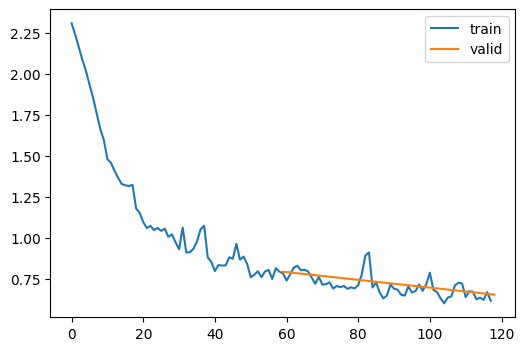

In [42]:
metrics = MetricsCallback(accuracy=MulticlassAccuracy())
cbs = [TrainCallback(), DeviceCallback(), metrics, ProgressCallback(plot=True)]

learner = Learner(model=model,
                  data_loaders=data_loaders,
                  loss_function=F.cross_entropy,
                  learning_rate=0.2,
                  callbacks=cbs)

learner.fit(2)

## Updated versions

We noticed that `contextlib.context_manager` has a surprising "feature" which doesn't let us raise an exception before the `yield`. Therefore we've replaced the context manager with a decorator in this updated version of `Learner`. We have also added a few more callbacks in `one_epoch()`.

In [43]:
#|export
class WithCallbacks:
    def __init__(self, callback_name):
        """
        Initialize a WithCallbacks object.

        Args:
        - callback_name (str): Name of the callback.
        """
        self.callback_name = callback_name

    def __call__(self, func):
        """
        Callable method to be used as a decorator.

        Args:
        - func (callable): The function to be decorated.

        Returns:
        - callable: The decorated function.
        """
        def decorated_function(learner, *args, **kwargs):
            """
            Decorated function that wraps the original function with callback handling.

            Args:
            - learner (Learner): The learner object representing the training process.
            - *args: Positional arguments for the original function.
            - **kwargs: Keyword arguments for the original function.

            Returns:
            - None
            """
            try:
                learner.callback(f'before_{self.callback_name}')
                func(learner, *args, **kwargs)
                learner.callback(f'after_{self.callback_name}')
            except globals()[f'Cancel{self.callback_name.title()}Exception']:
                pass
            finally:
                learner.callback(f'cleanup_{self.callback_name}')
        return decorated_function

In [44]:
#|export
class Learner:
    def __init__(self, model, data_loaders=(0,), loss_function=F.mse_loss, learning_rate=0.1, callbacks=None, optimizer_function=optim.SGD):
        """
        Initialize a Learner object.

        Args:
        - model: The model to be trained.
        - data_loaders: The data loaders for training and validation.
        - loss_func: The loss function.
        - learning_rate: The learning rate.
        - callbacks: List of callbacks.
        - optimizer_func: The optimizer function.
        """
        callbacks = fc.L(callbacks)
        fc.store_attr()

    @WithCallbacks('batch')
    def _one_batch(self):
        """
        Perform a single training batch.

        Returns:
        - None
        """
        self.predict()
        self.callback('after_predict')
        self.calculate_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @WithCallbacks('epoch')
    def _one_epoch(self):
        """
        Perform a single training epoch.

        Returns:
        - None
        """
        for self.iteration, self.batch in enumerate(self.data_loader):
            self._one_batch()

    def one_epoch(self, is_training):
        """
        Perform one epoch of training or validation.

        Args:
        - training (bool): Whether it is a training epoch.

        Returns:
        - None
        """
        self.model.train(is_training)
        self.data_loader = self.data_loaders.train_loader if is_training else self.data_loaders.valid_loader
        self._one_epoch()

    @WithCallbacks('fit')
    def _fit(self, train, valid):
        """
        Fit the model.

        Args:
        - train (bool): Whether to train the model.
        - valid (bool): Whether to validate the model.

        Returns:
        - None
        """
        for self.epoch in self.epochs:
            if train:
                self.one_epoch(True)
            if valid:
                torch.no_grad()(self.one_epoch)(False)

    def fit(self, num_epochs=1, train=True, valid=True, callbacks=None, learning_rate=None):
        """
        Train the model.

        Args:
        - num_epochs (int): Number of epochs.
        - train (bool): Whether to train the model.
        - valid (bool): Whether to validate the model.
        - callbacks: List of callbacks.
        - learning_rate: The learning rate.

        Returns:
        - None
        """
        callbacks = fc.L(callbacks)
        for callback in callbacks:
            self.callbacks.append(callback)
        try:
            self.num_epochs = num_epochs
            self.epochs = range(num_epochs)
            if learning_rate is None:
                learning_rate = self.learning_rate
            if self.optimizer_function:
                self.optimizer = self.optimizer_function(self.model.parameters(), learning_rate)
            self._fit(train, valid)
        finally:
            for callback in callbacks:
                self.callbacks.remove(callback)

    def __getattr__(self, name):
        """
        Get an attribute.

        Args:
        - name (str): Name of the attribute.

        Returns:
        - Attribute value.
        """
        if name in ('predict', 'calculate_loss', 'backward', 'step', 'zero_grad'):
            return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_name):
        """
        Perform a callback.

        Args:
        - method_name (str): Name of the method to be called.

        Returns:
        - None
        """
        run_callbacks(self.callbacks, method_name, self)

    @property
    def training(self):
        """
        Check if the model is in training mode.

        Returns:
        - bool: True if training, False otherwise.
        """
        return self.model.training

accuracy,loss,epoch,train
0.606,1.176,0,train
0.702,0.796,0,eval


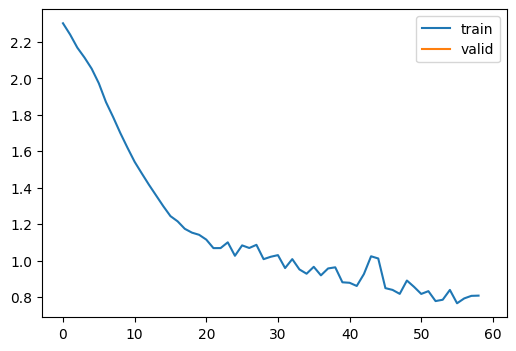

In [45]:
model = get_model()
metrics = MetricsCallback(accuracy=MulticlassAccuracy())
cbs = [TrainCallback(), DeviceCallback(), metrics, ProgressCallback(plot=True)]

learner = Learner(model=model,
                  data_loaders=data_loaders,
                  loss_function=F.cross_entropy,
                  learning_rate=0.2,
                  callbacks=cbs)

learner.fit(1)

## TrainLearner and MomentumLearner

In [47]:
#|export
class TrainLearner(Learner):
    def predict(self):
        """
        Make predictions using the model.

        Returns:
        - None
        """
        self.predictions = self.model(self.batch[0])

    def calculate_loss(self):
        """
        Calculate the loss.

        Returns:
        - None
        """
        self.loss = self.loss_function(self.predictions, self.batch[1])

    def backward(self):
        """
        Backpropagate the loss.

        Returns:
        - None
        """
        self.loss.backward()

    def step(self):
        """
        Take a step using the optimizer.

        Returns:
        - None
        """
        self.optimizer.step()

    def zero_grad(self):
        """
        Zero the gradients.

        Returns:
        - None
        """
        self.optimizer.zero_grad()

In [48]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, data_loaders, loss_function, learning_rate=None, callbacks=None, optimizer_function=optim.SGD, momentum=0.85):
        """
        Initializes a MomentumLearner.

        Args:
        - model: The neural network model.
        - dls: The data loaders.
        - loss_func: The loss function.
        - learning_rate: The learning rate.
        - callbacks: List of callbacks.
        - optimizer_func: The optimizer function.
        - momentum: The momentum value for SGD optimizer.

        Returns:
        - None
        """
        self.momentum = momentum
        super().__init__(model, data_loaders, loss_function, learning_rate, callbacks, optimizer_function)

    def zero_grad(self):
        """
        Zero the gradients with momentum.

        Returns:
        - None
        """
        with torch.no_grad():
            for param in self.model.parameters():
                param.grad *= self.momentum

accuracy,loss,epoch,train
0.674,0.976,0,train
0.789,0.588,0,eval


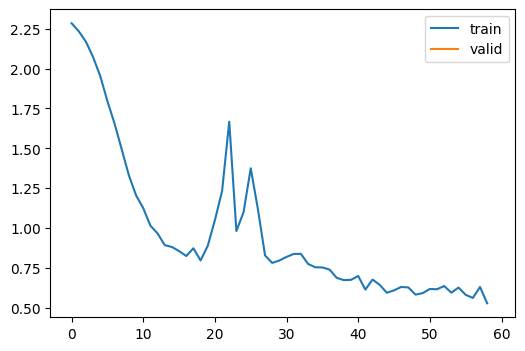

In [49]:
# NB: No TrainCB
model = get_model()
metrics = MetricsCallback(accuracy=MulticlassAccuracy())
cbs = [DeviceCallback(), metrics, ProgressCallback(plot=True)]

learner = MomentumLearner(model=model,
                  data_loaders=data_loaders,
                  loss_function=F.cross_entropy,
                  learning_rate=0.1,
                  callbacks=cbs)

learner.fit(1)

## LRFinderCB

In [50]:
class LRFinderCallback(Callback):
    def __init__(self, lr_multiplier=1.3):
        """
        Initializes an LRFinderCB.

        Args:
        - lr_multiplier: The learning rate multiplier.

        Returns:
        - None
        """
        self.lr_multiplier = lr_multiplier
        super().__init__()

    def before_fit(self, learner):
        """
        Callback before fitting.

        Args:
        - learner: The learner object.

        Returns:
        - None
        """
        self.learning_rates = []
        self.losses = []
        self.min_loss = math.inf

    def after_batch(self, learner):
        """
        Callback after processing each batch.

        Args:
        - learner: The learner object.

        Returns:
        - None
        """
        if not learner.training:
            raise CancelEpochException()
        
        current_lr = learner.optimizer.param_groups[0]['lr']
        self.learning_rates.append(current_lr)
        
        loss = to_cpu(learner.loss)
        self.losses.append(loss)
        
        if loss < self.min_loss:
            self.min_loss = loss
        
        if loss > self.min_loss * 3:
            raise CancelFitException()
        
        for param_group in learner.optimizer.param_groups:
            param_group['lr'] *= self.lr_multiplier

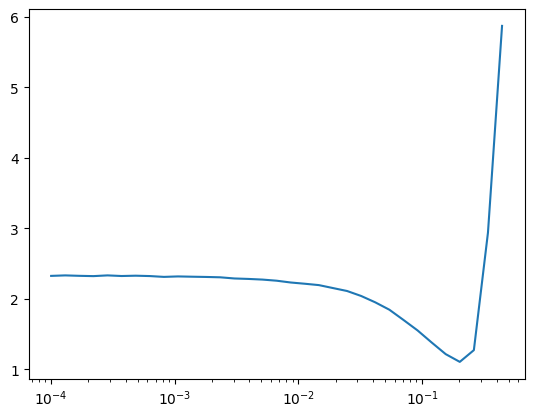

In [51]:
model = get_model()
lrfind = LRFinderCallback()
cbs = [DeviceCallback(), lrfind]

learner = MomentumLearner(model=model,
                  data_loaders=data_loaders,
                  loss_function=F.cross_entropy,
                  learning_rate=1e-4,
                  callbacks=cbs)

learner.fit(1)
plt.plot(lrfind.learning_rates, lrfind.losses)
plt.xscale('log')

In [52]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

[ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)

In [53]:
#|export
class LRFinderCallback(Callback):
    def __init__(self, lr_multiplier=1.3, max_multiplier=3):
        """
        Initializes an LRFinderCB.

        Args:
        - lr_multiplier: The learning rate multiplier.
        - max_multiplier: The maximum multiplier for the learning rate.

        Returns:
        - None
        """
        self.lr_multiplier = lr_multiplier
        self.max_multiplier = max_multiplier
        super().__init__()

    def before_fit(self, learner):
        """
        Callback before fitting.

        Args:
        - learner: The learner object.

        Returns:
        - None
        """
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.optimizer, self.lr_multiplier)
        self.learning_rates = []
        self.losses = []
        self.min_loss = math.inf

    def after_batch(self, learner):
        """
        Callback after processing each batch.

        Args:
        - learner: The learner object.

        Returns:
        - None
        """
        if not learner.training:
            raise CancelEpochException()
        
        current_lr = learner.optimizer.param_groups[0]['lr']
        self.learning_rates.append(current_lr)
        
        loss = to_cpu(learner.loss)
        self.losses.append(loss)
        
        if loss < self.min_loss:
            self.min_loss = loss
        
        if math.isnan(loss) or (loss > self.min_loss * self.max_multiplier):
            raise CancelFitException()
        
        self.scheduler.step()

    def cleanup_fit(self, learner):
        """
        Callback after the fit is completed.

        Args:
        - learner: The learner object.

        Returns:
        - None
        """
        plt.plot(self.learning_rates, self.losses)
        plt.xscale('log')

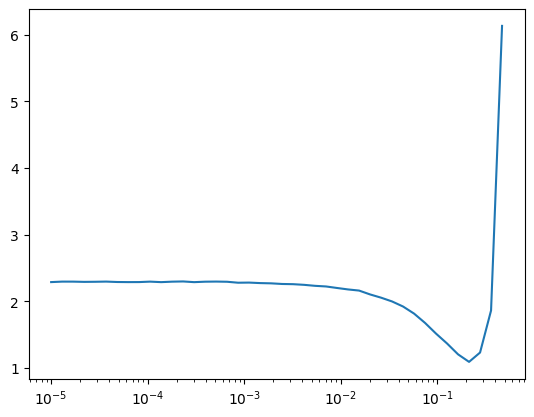

In [54]:
model = get_model()
cbs = [DeviceCallback()]

learner = MomentumLearner(model=model,
                  data_loaders=data_loaders,
                  loss_function=F.cross_entropy,
                  learning_rate=1e-5,
                  callbacks=cbs)

learner.fit(3, callbacks=LRFinderCallback())

In [55]:
#|export
@fc.patch
def find_lr(self: Learner, lr_multiplier=1.3, max_multiplier=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, 
             learning_rate=start_lr, 
             callbacks=LRFinderCallback(lr_multiplier=lr_multiplier, max_multiplier=max_multiplier))

`find_lr` is just a shorter way of using `LRFinderCB`.

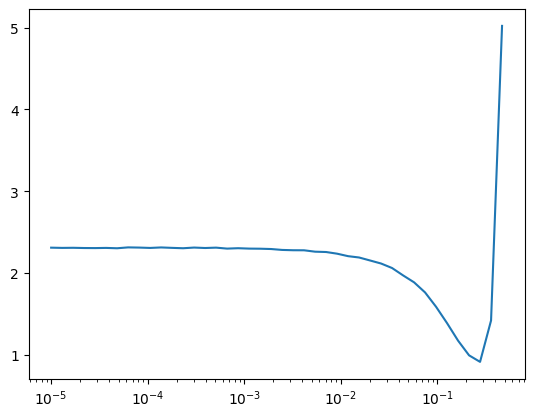

In [56]:
MomentumLearner(model=get_model(),
                  data_loaders=data_loaders,
                  loss_function=F.cross_entropy,
                  callbacks=cbs).find_lr()

## Export -

In [57]:
import nbdev; nbdev.nbdev_export()